# IMDB Sentiment Analysis

The data is split evenly with 25k reviews intended for training and 25k for testing your classifier. Moreover, each set has 12.5k positive and 12.5k negative reviews.

IMDb lets users rate movies on a scale from 1 to 10. To label these reviews the curator of the data labeled anything with ≤ 4 stars as negative and anything with ≥ 7 stars as positive. Reviews with 5 or 6 stars were left out.

**Import the required libraries**

In [1]:
import numpy as np
import pandas as pd
import os
import re
import warnings
warnings.filterwarnings("ignore")

**Load Data**

In [3]:
from datasets import load_dataset_builder
ds_builder = load_dataset_builder("imdb")

# Inspect dataset description
print(ds_builder.info.description)

# Inspect dataset features
print(ds_builder.info.features)

Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['neg', 'pos'], id=None)}


In [4]:
from datasets import load_dataset

reviews_train = load_dataset("imdb", split="train")
reviews_test = load_dataset("imdb", split="test")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to C:\Users\alber\.cache\huggingface\datasets\imdb\plain_text\1.0.0\2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


Using the latest cached version of the module from C:\Users\alber\.cache\huggingface\modules\datasets_modules\datasets\imdb\2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1 (last modified on Sun Jun 19 14:33:12 2022) since it couldn't be found locally at imdb., or remotely on the Hugging Face Hub.
Reusing dataset imdb (C:\Users\alber\.cache\huggingface\datasets\imdb\plain_text\1.0.0\2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


In [7]:
# reviews_train = []
# for line in open('C:/Users/Daney/Desktop/Archivos/Material/Databases/NLP/IMDB/full_train.txt', 'r', encoding='latin1'):
    
#     reviews_train.append(line.strip())
    
# reviews_test = []
# for line in open('C:/Users/Daney/Desktop/Archivos/Material/Databases/NLP/IMDB/full_test.txt', 'r', encoding='latin1'):
    
#     reviews_test.append(line.strip())

In [9]:
labels_train = reviews_train['label']
labels_test = reviews_test['label']

reviews_train = reviews_train['text']
reviews_test = reviews_test['text']

**See one of the elements in the list**

In [12]:
print(len(reviews_train))
print(len(reviews_test))
reviews_train[5]

25000
25000


"I would put this at the top of my list of films in the category of unwatchable trash! There are films that are bad, but the worst kind are the ones that are unwatchable but you are suppose to like them because they are supposed to be good for you! The sex sequences, so shocking in its day, couldn't even arouse a rabbit. The so called controversial politics is strictly high school sophomore amateur night Marxism. The film is self-consciously arty in the worst sense of the term. The photography is in a harsh grainy black and white. Some scenes are out of focus or taken from the wrong angle. Even the sound is bad! And some people call this art?<br /><br />"

The raw text is pretty messy for these reviews so before we can do any analytics we need to clean things up


**Use Regular expressions to remove the non text characters, and the html tags**

In [13]:
import re

# Remover todos los signos de puntuación, exclamaciones...
# Tb pasamos a minuscula y nos cargamos etiquetas HTML
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(reviews):
    
    # Para todas las reviews en minuscula, sustituye algunas cosas por espacio y otras por vacio.
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    
    return reviews

# Reviews tras aplicar la limpieza
reviews_train_clean = preprocess_reviews(reviews_train)
reviews_test_clean = preprocess_reviews(reviews_test)

In [14]:
reviews_train_clean[5]

"i would put this at the top of my list of films in the category of unwatchable trash there are films that are bad but the worst kind are the ones that are unwatchable but you are suppose to like them because they are supposed to be good for you the sex sequences so shocking in its day couldn't even arouse a rabbit the so called controversial politics is strictly high school sophomore amateur night marxism the film is self consciously arty in the worst sense of the term the photography is in a harsh grainy black and white some scenes are out of focus or taken from the wrong angle even the sound is bad and some people call this art "

# Vectorization
In order for this data to make sense to our machine learning algorithm we’ll need to convert each review to a numeric representation, which we call vectorization.

The simplest form of this is to create one very large matrix with one column for every unique word in your corpus (where the corpus is all 50k reviews in our case). Then we transform each review into one row containing 0s and 1s, where 1 means that the word in the corpus corresponding to that column appears in that review. That being said, each row of the matrix will be very sparse (mostly zeros). This process is also known as one hot encoding. Use the *CountVectorizer* method.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Si aparece una palabra en una review, le pone un 1. Da igual que aparezca 100 veces, no cuenta. Xq binary=True
# Solo pone 1s cuando detecta una palabra en una review
baseline_vectorizer = CountVectorizer(binary=True)
baseline_vectorizer.fit(reviews_train_clean)

# Reviews en formato vector de palabras. El mismo vectorizador a test, tiene que mantener la estructura
X_baseline = baseline_vectorizer.transform(reviews_train_clean)
X_test_baseline = baseline_vectorizer.transform(reviews_test_clean)

In [35]:
np.histogram(X_baseline[0].toarray().reshape(-1))

(array([86202,     0,     0,     0,     0,     0,     0,     0,     0,
          172], dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

<AxesSubplot:ylabel='Count'>

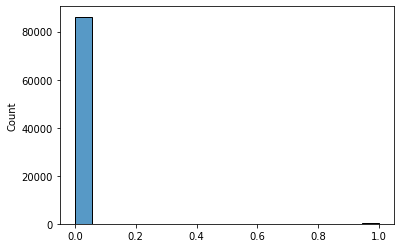

In [34]:
import seaborn as sns
sns.histplot(X_baseline[0].toarray().reshape(-1))

In [16]:
print(X_baseline.shape)

# Asigna un numero segun el orden de aparicion
baseline_vectorizer.vocabulary_

(25000, 86374)


{'rented': 62973,
 'am': 2353,
 'curious': 17548,
 'yellow': 85603,
 'from': 29485,
 'my': 51121,
 'video': 81913,
 'store': 72733,
 'because': 6502,
 'of': 53454,
 'all': 2022,
 'the': 76137,
 'controversy': 15895,
 'that': 76084,
 'surrounded': 74215,
 'it': 39355,
 'when': 83770,
 'was': 82973,
 'first': 27857,
 'released': 62700,
 'in': 37458,
 'also': 2248,
 'heard': 34207,
 'at': 4496,
 'seized': 67311,
 'by': 10595,
 'us': 81042,
 'customs': 17644,
 'if': 36913,
 'ever': 25296,
 'tried': 78507,
 'to': 77311,
 'enter': 24467,
 'this': 76523,
 'country': 16482,
 'therefore': 76309,
 'being': 6763,
 'fan': 26486,
 'films': 27599,
 'considered': 15577,
 'controversial': 15890,
 'really': 61803,
 'had': 33145,
 'see': 67179,
 'for': 28638,
 'myself': 51153,
 'plot': 57943,
 'is': 39189,
 'centered': 12144,
 'around': 3977,
 'young': 85803,
 'swedish': 74452,
 'drama': 22045,
 'student': 73191,
 'named': 51350,
 'lena': 43615,
 'who': 83944,
 'wants': 82850,
 'learn': 43353,
 'everyth

In [39]:
vectorizer_c = CountVectorizer()
vectorizer_c.fit(reviews_train_clean)

# Ya no es binaria la aparicion, sino un conteo por palabra
X_baseline_c = vectorizer_c.transform(reviews_train_clean)

In [40]:
print(X_baseline_c.shape)
print(len(vectorizer_c.get_feature_names())) # Las mismas
#X_baseline_c.toarray()

(25000, 86374)
86374


In [41]:
# Matriz demasiado grande como para que numpy la imprima por pantalla
X_baseline_c

<25000x86374 sparse matrix of type '<class 'numpy.int64'>'
	with 3409819 stored elements in Compressed Sparse Row format>

In [43]:
np.histogram(X_baseline_c[0].toarray().reshape(-1))

(array([86202,   129,    22,     9,     5,     1,     2,     0,     1,
            3], dtype=int64),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))

In [45]:
xb = X_baseline_c[0].toarray().reshape(-1).copy()
xb[xb!=0]

array([ 4,  1,  1,  1,  3,  1,  8,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,
        2,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  2,  1,  2,  1,  1,  1,
        1,  1,  1,  3,  1,  2,  1,  2,  1,  4,  1,  1,  2,  2,  1,  1,  1,
        2,  1,  1, 10,  1,  1,  4,  2,  6,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  6,
        1,  2,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,
        1,  3,  1,  1,  2,  1,  1,  5,  3,  1,  1,  1,  3,  2,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  4, 10,  1,  2,  1,  1,  4,
        1,  9,  1,  1,  1,  1,  1,  1,  2,  1,  3,  2,  1,  1,  1,  1,  1,
        3,  1], dtype=int64)

In [50]:
print(len(xb[xb!=0]))
print(sum(xb))

172
274


<AxesSubplot:ylabel='Count'>

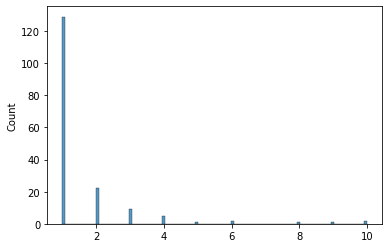

In [47]:
sns.histplot(xb[xb!=0])

In [46]:
vectorizer_c.vocabulary_

{'rented': 62973,
 'am': 2353,
 'curious': 17548,
 'yellow': 85603,
 'from': 29485,
 'my': 51121,
 'video': 81913,
 'store': 72733,
 'because': 6502,
 'of': 53454,
 'all': 2022,
 'the': 76137,
 'controversy': 15895,
 'that': 76084,
 'surrounded': 74215,
 'it': 39355,
 'when': 83770,
 'was': 82973,
 'first': 27857,
 'released': 62700,
 'in': 37458,
 'also': 2248,
 'heard': 34207,
 'at': 4496,
 'seized': 67311,
 'by': 10595,
 'us': 81042,
 'customs': 17644,
 'if': 36913,
 'ever': 25296,
 'tried': 78507,
 'to': 77311,
 'enter': 24467,
 'this': 76523,
 'country': 16482,
 'therefore': 76309,
 'being': 6763,
 'fan': 26486,
 'films': 27599,
 'considered': 15577,
 'controversial': 15890,
 'really': 61803,
 'had': 33145,
 'see': 67179,
 'for': 28638,
 'myself': 51153,
 'plot': 57943,
 'is': 39189,
 'centered': 12144,
 'around': 3977,
 'young': 85803,
 'swedish': 74452,
 'drama': 22045,
 'student': 73191,
 'named': 51350,
 'lena': 43615,
 'who': 83944,
 'wants': 82850,
 'learn': 43353,
 'everyth

# Train a Baseline Model

Train a Logistic Regression model after transforming the data with CountVectorized

* They’re easy to interpret
* Linear models tend to perform well on sparse datasets like this one
* They learn very fast compared to other algorithms.

Test models with C values of [0.01, 0.05, 0.25, 0.5, 1] and see wich is the best value for C, and calculate the accuracy

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Los comentarios vienen ordenados. Los primeros 12,5k son negativos
# A test le ocurre lo mismo
target = [1 if i < 12500 else 0 for i in range(25000)]


def train_model(X_TRAIN, X_TEST):
    
    lr = LogisticRegression()
    
    params = {
        'C': [0.01, 0.05, 0.25, 0.5, 1]
    }
    
    grid = GridSearchCV(lr, params, cv=5)
    grid.fit(X_TRAIN, target)

    print ("Final Accuracy: %s" % accuracy_score(target, grid.best_estimator_.predict(X_TEST)))
    
train_model(X_baseline, X_test_baseline)

Final Accuracy: 0.88176


# Remove Stop Words

Stop words are the very common words like ‘if’, ‘but’, ‘we’, ‘he’, ‘she’, and ‘they’. We can usually remove these words without changing the semantics of a text and doing so often (but not always) improves the performance of a model. Removing these stop words becomes a lot more useful when we start using longer word sequences as model features (see n-grams below).

Before we apply the CountVectorized, lets remove the stopwords, included in nltk.corpus

Then apply the CountVectorizer, and train the Logistic regression model and obtain the accuracy.

In [53]:
# Hay que bajarse las stopwords de nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [54]:
# Para visualizar los stopwords de inglés
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [57]:
len(stopwords.words('english')), len(stopwords.words('spanish'))

(179, 313)

In [55]:
# Para visualizarlas en español
stopwords.words('spanish')[:10]

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [58]:
from nltk.corpus import stopwords

# Aplicamos la eliminacion de las palabras directamente sobre las reviews
# Demasiado manual. Mejor sobre el CountVectorizer (ver abajo)
english_stop_words = stopwords.words('english')


def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        
        # Para cada review elimina las stopwords, y separa todas las palabras por espacio
        removed_stop_words.append(
            ' '.join([word for word in review.split() if word not in english_stop_words])
        )
        
    return removed_stop_words

# Se lo aplicamos antes de vectorizar
no_stop_words_train = remove_stop_words(reviews_train_clean)
no_stop_words_test = remove_stop_words(reviews_test_clean)

In [59]:
'''
Vectorizamos tras eliminar las stop words
Ver docu, tiene cosas interesantes como lowercase=True. Lo hace antes de vectorizar, 
o el argumento stopwords
'''
cv = CountVectorizer(binary=True)
cv.fit(no_stop_words_train)

X = cv.transform(no_stop_words_train)

# Se aplica el mismo a test
X_test = cv.transform(no_stop_words_test)

# Y entrenamos
train_model(X, X_test)

Final Accuracy: 0.87968


In [60]:
'''
X_baseline tras aplicar el vectorizador tal cual en los datos
X tras aplicar el vectorizador despues de eliminar las stop words. No se carga muchas
'''
print(X_baseline.shape)
print(X.shape)
print("Stop words eliminadas:", X_baseline.shape[1] - X.shape[1])

(25000, 86374)
(25000, 86357)
Stop words eliminadas: 17


In [61]:
'''
El resultado de este codigo es practicamente igual que el anterior, pero elimina mas stopwords
'''

cv = CountVectorizer(binary=True,
                     stop_words = english_stop_words)

cv.fit(reviews_train_clean)

X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)

train_model(X, X_test)

Final Accuracy: 0.88


In [63]:
'''
X_baseline tras aplicar el vectorizador tal cual en los datos
X tras aplicar el vectorizador despues de eliminar las stop words
En este caso elimina mas, tiene pinta de xq el countvectorizer tokeniza mejor las palabras
de lo que lo hemos hecho nosotros en la funcion remove_stop_words. Por ejemplo "it's" serian dos palabras
'''
print(X_baseline.shape)
print(X.shape)
print("Stop words eliminadas:", X_baseline.shape[1] - X.shape[1])

(25000, 86374)
(25000, 86229)
Stop words eliminadas: 145


**Note:** In practice, an easier way to remove stop words is to just use the stop_words argument with any of scikit-learn’s ‘Vectorizer’ classes. If you want to use NLTK’s full list of stop words you can do stop_words='english’. In practice I’ve found that using NLTK’s list actually decreases my performance because its too expansive, so I usually supply my own list of words. For example, stop_words=['in','of','at','a','the'] .

A common next step in text preprocessing is to normalize the words in your corpus by trying to convert all of the different forms of a given word into one. Two methods that exist for this are Stemming and Lemmatization.

# Stemming

https://www.geeksforgeeks.org/snowball-stemmer-nlp/

Stemming is considered to be the more crude/brute-force approach to normalization (although this doesn’t necessarily mean that it will perform worse). There’s several algorithms, but in general they all use basic rules to chop off the ends of words.

NLTK has several stemming algorithm implementations. We’ll use the Porter stemmer. Most used:
* PorterStemmer
* SnowballStemmer

Apply a PoterStemmer, vectorize, and train the model again

In [64]:
'''
El stemmer se aplica sobre cada palabra. Las recorta eliminando plurales y tiempos verbales
Modifica muy poco cada palabra
'''

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

plurals = ['caresses', 'flies', 'dies', 'mules', 'denied',
            'died', 'agreed', 'owned', 'humbled', 'sized',
            'meeting', 'stating', 'siezing', 'itemization',
            'sensational', 'traditional', 'reference', 'colonizer',
            'plotted']
singles = [stemmer.stem(plural) for plural in plurals]

print(' '.join(singles))

caress fli die mule deni die agre own humbl size meet state siez item sensat tradit refer colon plot


In [65]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

plurals = ['caresses', 'flies', 'dies', 'mules', 'denied',
            'died', 'agreed', 'owned', 'humbled', 'sized',
            'meeting', 'stating', 'siezing', 'itemization',
            'sensational', 'traditional', 'reference', 'colonizer',
            'plotted']
singles = [stemmer.stem(plural) for plural in plurals]

print(' '.join(singles))

caress fli die mule deni die agre own humbl size meet state siez item sensat tradit refer colon plot


In [66]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('spanish')

plurals = ['corriendo', 'casas', 'playa', 'volando', 'volar', 'volveré']
singles = [stemmer.stem(plural) for plural in plurals]

print(' '.join(singles))

corr cas play vol vol volv


In [67]:
# Aplicamos a mano. Los stemmers no eliminan palabras, solo quitan sufijos, y ahora habrá más palabras que sean iguales
def get_stemmed_text(corpus):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

stemmed_reviews_train = get_stemmed_text(reviews_train_clean)
stemmed_reviews_test = get_stemmed_text(reviews_test_clean)

cv = CountVectorizer(binary=True, stop_words = english_stop_words)
cv.fit(stemmed_reviews_train)

X_stem = cv.transform(stemmed_reviews_train)
X_test = cv.transform(stemmed_reviews_test)

train_model(X_stem, X_test)

Final Accuracy: 0.87688


In [68]:
# No elimina palabras. Solo recorta sufijos y agrupa tipos de palabras.
# Como resultado dará menos palabras debido al agrupado. Se carga unas cuantas letras de las palabras
print(X_baseline.shape)
print(X_stem.shape)
print("Diff X normal y X tras stemmer y vectorización:", X_baseline.shape[1] - X_stem.shape[1])

(25000, 86374)
(25000, 66083)
Diff X normal y X tras stemmer y vectorización: 20291


# Lemmatization

Lemmatization works by identifying the part-of-speech of a given word and then applying more complex rules to transform the word into its true root.

In [39]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Daney\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [40]:
'''
La diferencia con el stemming es que la lematización tiene en cuenta la morfología
de la palabra, sustituyendola por la raiz, no recortándola. Y no es tan restrictivo como el stemming.
Necesita un buen diccionario con mapeos, como wordnet

En nltk no hay lematizadores en español. Habria que bajarse algun paquete como pip install es-lemmatizer
'''

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

plurals = ['caresses', 'flies', 'dies', 'mules', 'studies',
            'died', 'agreed', 'owned', 'humbled', 'sized',
            'meeting', 'stating', 'siezing', 'itemization',
            'sensational', 'traditional', 'reference', 'colonizer',
            'plotted']
singles = [lemmatizer.lemmatize(plural) for plural in plurals]

print(' '.join(singles))

caress fly dy mule study died agreed owned humbled sized meeting stating siezing itemization sensational traditional reference colonizer plotted


In [43]:
def get_lemmatized_text(corpus):
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

# Lematizamos las reviews
lemmatized_reviews_train = get_lemmatized_text(reviews_train_clean)
lemmatized_reviews_test = get_lemmatized_text(reviews_test_clean)

# Vectorizamos con conteo tras lematizar
cv = CountVectorizer(binary=True, stop_words = english_stop_words)
cv.fit(lemmatized_reviews_train)

X = cv.transform(lemmatized_reviews_train)
X_test = cv.transform(lemmatized_reviews_test)

train_model(X, X_test)

Final Accuracy: 0.87812


In [44]:
# Elimina menos que con el stemmer. Normal, el stemmer recorta mucho del sufijo
print(X_baseline.shape)
print(X.shape)
print("Diff X normal y X tras lematizador y vectorización:", X_baseline.shape[1] - X.shape[1])

(25000, 87063)
(25000, 80181)
Diff X normal y X tras lematizador y vectorización: 6882


# n-grams

We can potentially add more predictive power to our model by adding two or three word sequences (bigrams or trigrams) as well. For example, if a review had the three word sequence “didn’t love movie” we would only consider these words individually with a unigram-only model and probably not capture that this is actually a negative sentiment because the word ‘love’ by itself is going to be highly correlated with a positive review.

The scikit-learn library makes this really easy to play around with. Just use the ngram_range argument with any of the ‘Vectorizer’ classes.

In [48]:
from nltk import ngrams

sentence = 'this is foo bar'

two = ngrams(sentence.split(), 2)
three = ngrams(sentence.split(), 3)

for grams in two:
  print(grams)
print('###############')
for grams in three:
  print(grams)

'''
Puede ser bigramas si ngram_range=(2,2), o trigramas (3,3)...
Algunas palabras las elimina, como 'a'. Cuidado con eso a la hora de hacer el conteo
ngram_range=(1, 3) significa las palabras por separado, los bigramas y los trigramas
Ojo que esto aumenta muchisimo el espacio de features
'''
ngram_vectorizer = CountVectorizer(binary=True,
                                   ngram_range=(1, 3))

vector = ngram_vectorizer.fit_transform([sentence]).toarray()
print(vector)
print(len(vector[0]))

('this', 'is')
('is', 'foo')
('foo', 'bar')
###############
('this', 'is', 'foo')
('is', 'foo', 'bar')
[[1 1 1 1 1 1 1 1 1]]
9


In [49]:
'''
Va como argumento del CountVectorizer
'''
ngram_vectorizer = CountVectorizer(binary=True, stop_words = english_stop_words,
                                   ngram_range=(1, 2))

ngram_vectorizer.fit(reviews_train_clean)

X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

train_model(X, X_test)

Final Accuracy: 0.889


In [50]:
# Añade 1448047 n gramas. Cuanto mas ngramas, mayor será el espacio de features
print(X_baseline.shape)
print(X.shape)
print("Diff X normal y X tras lematizador y vectorización:", X_baseline.shape[1] - X.shape[1])

(25000, 87063)
(25000, 1865232)
Diff X normal y X tras lematizador y vectorización: -1778169


# TF-IDF

Another common way to represent each document in a corpus is to use the tf-idf statistic (term frequency-inverse document frequency) for each word, which is a weighting factor that we can use in place of binary or word count representations.

There are several ways to do tf-idf transformation but in a nutshell, **tf-idf aims to represent the number of times a given word appears in a document (a movie review in our case) relative to the number of documents in the corpus that the word appears in**.

**Note:** Now that we’ve gone over n-grams, when I refer to ‘words’ I really mean any n-gram (sequence of words) if the model is using an n greater than one.

In [51]:
'''
ln(N + 1 / df + 1) + 1
Cuanto mas comun, menor es el TDFIDF. Cuanto mas rara, mayor
'''
# Numero de documentos
N = 3

# Numero de veces que aparece
df = 2

1 + np.log((N + 1)/(df + 1))

1.2876820724517808

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfTransformer
'''
Cuanto mas comun, mas bajo es el TfidfVectorizer
'''
sent1 = 'My name is Ralph'
sent2 = 'Ralph is fat'
sent3 = 'Ralph'

test = TfidfVectorizer()
test.fit_transform([sent1, sent2, sent3])
print(test.idf_)
print(test.get_feature_names())

[1.69314718 1.28768207 1.69314718 1.69314718 1.        ]
['fat', 'is', 'my', 'name', 'ralph']


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(reviews_train_clean)
X = tfidf_vectorizer.transform(reviews_train_clean)
X_test = tfidf_vectorizer.transform(reviews_test_clean)


train_model(X, X_test)

Final Accuracy: 0.8822


# Support Vector Machines (SVM)

Recall that linear classifiers tend to work well on very sparse datasets (like the one we have). Another algorithm that can produce great results with a quick training time are Support Vector Machines with a linear kernel.

Build a model with an n-gram range from 1 to 2:

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# SVM con bigramas
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)



def train_model_svm(X_TRAIN, X_TEST):
    
    svm = LinearSVC()
    
    params = {
        'C': [0.01, 0.05, 0.25, 0.5, 1]
    }
    
    grid = GridSearchCV(svm, params, cv=5)
    grid.fit(X_TRAIN, target)

    print ("Final Accuracy: %s" % accuracy_score(target, grid.best_estimator_.predict(X_TEST)))
    

train_model_svm(X, X_test)

Final Accuracy: 0.89748


# Final Model

Removing a small set of stop words along with an n-gram range from 1 to 3 and a linear support vector classifier shows the best results.

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC


stop_words = ['in', 'of', 'at', 'a', 'the']
ngram_vectorizer = CountVectorizer(binary=True,
                                   ngram_range=(1, 3),
                                   stop_words=stop_words)

ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

train_model(X, X_test)

Final Accuracy: 0.89948


# Top Postitive and Negative Features

Obtain the most important features of the model.

In [58]:
cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)

log_reg = LogisticRegression(C=0.5)
log_reg.fit(X, target)

# Importancia de los coeficientes. En total, todas las palabras vectorizadas
print(len(log_reg.coef_[0]))

# Cada coeficiente va asociado a una palabra
cv.get_feature_names()

# Montamos un diccionario con palabra -> coeficiente
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), log_reg.coef_[0]
    )
}

87063


In [59]:

for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print(best_positive)
    
print('################################')
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print(best_negative)
    

('excellent', 1.3796015137688178)
('refreshing', 1.2806374144444463)
('perfect', 1.2012611851223425)
('superb', 1.1357241728322187)
('appreciated', 1.1339191120163457)
################################
('worst', -2.061496946266291)
('waste', -1.9184173016299815)
('disappointment', -1.6761904512261208)
('poorly', -1.657993242508792)
('awful', -1.5348355436989127)


In [207]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

print(model)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy: 86.22%


In [ ]:
# APPLY GRID SEARCH AND PIPELINES!